# GOES EUV Comparisons


Compare overlapping EUV observations for GOES 13 through 18.
- Determinee how well the fluxes match uxing correlations.

Identify which pairs most closely match to GOES R-Series (16,17,18). These satellites can be used to train with real-time data for one an operational models. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np
import numpy.ma as ma
import seaborn as sns

from itertools import combinations
from netCDF4 import Dataset

from astropy.coordinates import get_sun
from astropy.time import Time

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [2]:
df = pd.DataFrame()
df['DT'] = pd.date_range(start='2002-01-01',end='2025-07-16',freq='1min')

g_sat = []

# for these files the time is relative to 1970-01-01

f_dn = ["D:\data\GOES\EUVS\dn_geuv-l2-cpy1m_g15_s20100101_e20161231_v4-0-0.nc", \
    "D:\data\GOES\EUVS\dn_geuv-l2-cpy1m_g14_s20090101_e20161231_v4-0-0.nc", \
    "D:\data\GOES\EUVS\dn_geuv-l2-cpy1m_g13_s20060101_e20161231_v4-0-0.nc"]

f_dn = ["D:\data\GOES\EUVS\dn_geuv-l2-cpy1m_g13_s20060101_e20161231_v4-0-0.nc"]

for fi in f_dn:
    f = Dataset(fi)
    sat = fi.split('_')[2]
    g_sat.append(sat)
    d = pd.DataFrame({f'irr_1216_{sat}':f.variables['irr_1216_1nm'][:].compressed(), 
                    f'DateTime_{sat}':f.variables['time'][:][~f.variables['irr_1216_1nm'][:].mask]})
    d[f'DateTime_{sat}'] = pd.to_datetime(d[f'DateTime_{sat}'], unit='s').dt.round('min')
    df = df.merge(d, left_on='DT', right_on=f'DateTime_{sat}', how='outer')


In [3]:
# for these files the time is relative to 2000-01-01 12 UT

f_sci = ["D:\data\GOES\EUVS\dn_euvs-l2-avg1m_g19_s20250131_e20250715_v1-0-6.nc", \
        "D:\data\GOES\EUVS\sci_euvs-l2-avg1m_g16_s20170207_e20250406_v1-0-6.nc", \
        "D:\data\GOES\EUVS\sci_euvs-l2-avg1m_g17_s20180601_e20230109_v1-0-6.nc", \
        "D:\data\GOES\EUVS\sci_euvs-l2-avg1m_g18_s20220909_e20250713_v1-0-6.nc", \
        "D:\data\GOES\EUVS\sci_geuv-l2-avg1m_g14_s20090901_e20200304_v5-0-0.nc", \
        "D:\data\GOES\EUVS\sci_geuv-l2-avg1m_g15_s20100325_e20200304_v5-0-0.nc"]

dt_shift = pd.to_datetime('2000-01-01 12:00:00').value*1E-9 

for fi in f_sci:
    sat = fi.split('_')[2]
    g_sat.append(sat)
    print(sat)
    col = 'irr_1216_1nm' if sat in ['g14','g15'] else 'irr_1216'
    f = Dataset(fi)

    d = pd.DataFrame({f'irr_1216_{sat}':f.variables[col][:].compressed(), 
                    f'DateTime_{sat}':f.variables['time'][~f.variables[col][:].mask]})
    d[f'DateTime_{sat}'] = pd.to_datetime(d[f'DateTime_{sat}']+dt_shift, unit='s') 

    df = df.merge(d, left_on='DT', right_on=f'DateTime_{sat}', how='outer')

g19
g16
g17
g18
g14
g15


In [4]:
irr_cols = [f'irr_1216_{g}' for g in g_sat]
df['irr_1216_gx'] = np.nanmean(df[irr_cols].to_numpy(),axis=1)
g_sat.append('gx')

print(df.columns)
print(g_sat)
print(irr_cols)

Index(['DT', 'irr_1216_g13', 'DateTime_g13', 'irr_1216_g19', 'DateTime_g19',
       'irr_1216_g16', 'DateTime_g16', 'irr_1216_g17', 'DateTime_g17',
       'irr_1216_g18', 'DateTime_g18', 'irr_1216_g14', 'DateTime_g14',
       'irr_1216_g15', 'DateTime_g15', 'irr_1216_gx'],
      dtype='object')
['g13', 'g19', 'g16', 'g17', 'g18', 'g14', 'g15', 'gx']
['irr_1216_g13', 'irr_1216_g19', 'irr_1216_g16', 'irr_1216_g17', 'irr_1216_g18', 'irr_1216_g14', 'irr_1216_g15']


C:\Users\murph\AppData\Local\Temp\ipykernel_33088\4105151971.py:2: RuntimeWarning: Mean of empty slice
  df['irr_1216_gx'] = np.nanmean(df[irr_cols].to_numpy(),axis=1)


In [5]:
# get all combinations of the GOES 
# satellites that were loaded
# this will be for looking at how well 
# they relate
gcom = list(combinations(g_sat, 2))
gcom

[('g13', 'g19'),
 ('g13', 'g16'),
 ('g13', 'g17'),
 ('g13', 'g18'),
 ('g13', 'g14'),
 ('g13', 'g15'),
 ('g13', 'gx'),
 ('g19', 'g16'),
 ('g19', 'g17'),
 ('g19', 'g18'),
 ('g19', 'g14'),
 ('g19', 'g15'),
 ('g19', 'gx'),
 ('g16', 'g17'),
 ('g16', 'g18'),
 ('g16', 'g14'),
 ('g16', 'g15'),
 ('g16', 'gx'),
 ('g17', 'g18'),
 ('g17', 'g14'),
 ('g17', 'g15'),
 ('g17', 'gx'),
 ('g18', 'g14'),
 ('g18', 'g15'),
 ('g18', 'gx'),
 ('g14', 'g15'),
 ('g14', 'gx'),
 ('g15', 'gx')]

In [6]:
fit_par = pd.DataFrame()

df_c = pd.DataFrame({'sat':g_sat})
df_c = df_c.set_index('sat')
df_c[g_sat] = 1. 

# loop through satellite pairs to compare x-ray observations
for pr in gcom:
    cols = [f'irr_1216_{g}' for g in pr]
    pos = df_c.index == pr[0]
    df_c.loc[pos,pr[1]] = df[cols].dropna().corr()[cols[0]][cols[1]]
    pos = df_c.index == pr[1]
    df_c.loc[pos,pr[0]] = df[cols].dropna().corr()[cols[0]][cols[1]]

    # get the data to compare
    ol_df = df[cols].dropna()

    print(f'{pr} - overlapping elements: {ol_df.shape[0]}')
    if ol_df.shape[0] < 1: 
        continue

    regr = linear_model.LinearRegression()
    regr.fit(ol_df.iloc[:,0].to_numpy().reshape(ol_df.shape[0],1), ol_df.iloc[:,1].to_numpy())
    

    pred = regr.predict(ol_df.iloc[:,0].to_numpy().reshape(ol_df.shape[0],1))
    mae = mean_absolute_error(ol_df.iloc[:,1].to_numpy(),pred)
    mape = mean_absolute_percentage_error(ol_df.iloc[:,1].to_numpy(),pred)
    r2 = r2_score(ol_df.iloc[:,1].to_numpy(), pred)

    dmae = mean_absolute_error(ol_df.iloc[:,1].to_numpy(),ol_df.iloc[:,0].to_numpy())
    dmape = mean_absolute_percentage_error(ol_df.iloc[:,1].to_numpy(),ol_df.iloc[:,0].to_numpy())
    dr2 =  r2_score(ol_df.iloc[:,1].to_numpy(), ol_df.iloc[:,0].to_numpy())

    fit_df = pd.DataFrame({'x':pr[0],'y':pr[1],'com':'_'.join(pr), 
                            'm':regr.coef_, 'b':regr.intercept_, 
                            'mae':mae, 'mape':mape, 'r2':r2, 
                            'dmae':dmae, 'dmape':dmape, 'dr2':dr2 })
    
    fit_par = pd.concat([fit_par,fit_df], ignore_index=True)

    

('g13', 'g19') - overlapping elements: 0
('g13', 'g16') - overlapping elements: 0
('g13', 'g17') - overlapping elements: 0
('g13', 'g18') - overlapping elements: 0
('g13', 'g14') - overlapping elements: 162455
('g13', 'g15') - overlapping elements: 1769564
('g13', 'gx') - overlapping elements: 2339459
('g19', 'g16') - overlapping elements: 74303
('g19', 'g17') - overlapping elements: 0
('g19', 'g18') - overlapping elements: 210824
('g19', 'g14') - overlapping elements: 0
('g19', 'g15') - overlapping elements: 0
('g19', 'gx') - overlapping elements: 217694
('g16', 'g17') - overlapping elements: 2084868
('g16', 'g18') - overlapping elements: 1287091
('g16', 'g14') - overlapping elements: 1143461
('g16', 'g15') - overlapping elements: 1488602
('g16', 'gx') - overlapping elements: 4167913
('g17', 'g18') - overlapping elements: 161863
('g17', 'g14') - overlapping elements: 649591
('g17', 'g15') - overlapping elements: 649025
('g17', 'gx') - overlapping elements: 2122504
('g18', 'g14') - ove

<Axes: ylabel='sat'>

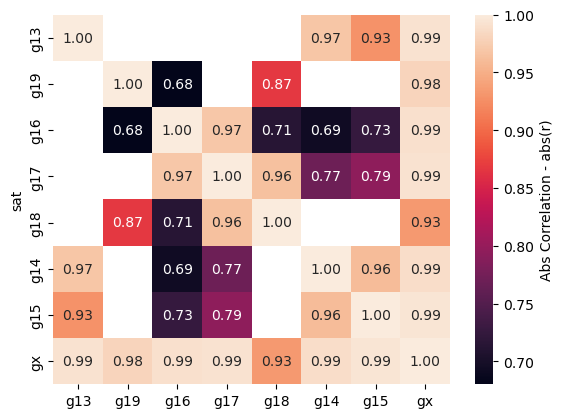

In [7]:
sns.heatmap(df_c.abs(),annot=True, fmt='.2f', cbar_kws={'label':'Abs Correlation - abs(r)'})

In [8]:
fit_par

,x,y,com,m,b,mae,mape,r2,dmae,dmape,dr2
0,g13,g14,g13_g14,0.974831,0.000129,0.000122,0.016911,0.937777,0.000131,0.018199,0.930033
1,g13,g15,g13_g15,0.993035,0.000116,0.000159,0.022590,0.862426,0.000167,0.023345,0.852963
2,g13,gx,g13_gx,1.009496,-0.000047,0.000066,0.008749,0.984241,0.000066,0.008700,0.983438
3,g19,g16,g19_g16,0.909340,0.000970,0.000138,0.022348,0.462637,0.000259,0.035575,0.410776
4,g19,g18,g19_g18,0.681338,0.002796,0.000115,0.016517,0.750745,0.000352,0.047088,0.463740
5,g19,gx,g19_gx,0.879033,0.001109,0.000063,0.008068,0.960989,0.000176,0.022893,0.911018
6,g16,g17,g16_g17,1.024780,-0.000144,0.000070,0.010592,0.938665,0.000078,0.011435,0.937326
7,g16,g18,g16_g18,0.683227,0.002743,0.000190,0.024592,0.508364,0.000195,0.025280,0.364653
8,g16,g14,g16_g14,0.786414,0.001198,0.000100,0.017578,0.480376,0.000137,0.023989,0.173376
9,g16,g15,g16_g15,0.851834,0.000824,0.000110,0.019177,0.527345,0.000124,0.021942,0.387845


## Append some files times

In [17]:
df.head(2)

,DT,irr_1216_g13,DateTime_g13,irr_1216_g19,DateTime_g19,irr_1216_g16,DateTime_g16,irr_1216_g17,DateTime_g17,irr_1216_g18,DateTime_g18,irr_1216_g14,DateTime_g14,irr_1216_g15,DateTime_g15,irr_1216_gx
0,2002-01-01 00:00:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
1,2002-01-01 00:01:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN


In [19]:
t = Time(df['DT'],scale='utc')
sun_pos = get_sun(t)

In [21]:
import datetime as dt
import numpy as np


def subsol(datetime):
    """Finds subsolar geocentric latitude and longitude.

    Parameters
    ----------
    datetime : :class:`datetime.datetime` or :class:`numpy.ndarray[datetime64]`
        Date and time in UTC (naive objects are treated as UTC)

    Returns
    -------
    sbsllat : float
        Latitude of subsolar point
    sbsllon : float
        Longitude of subsolar point

    Notes
    -----
    Based on formulas in Astronomical Almanac for the year 1996, p. C24.
    (U.S. Government Printing Office, 1994). Usable for years 1601-2100,
    inclusive. According to the Almanac, results are good to at least 0.01
    degree latitude and 0.025 degrees longitude between years 1950 and 2050.
    Accuracy for other years has not been tested. Every day is assumed to have
    exactly 86400 seconds; thus leap seconds that sometimes occur on December
    31 are ignored (their effect is below the accuracy threshold of the
    algorithm).

    After Fortran code by A. D. Richmond, NCAR. Translated from IDL
    by K. Laundal.

    """
    # Convert to year, day of year and seconds since midnight
    if isinstance(datetime, dt.datetime):
        year = np.asanyarray([datetime.year])
        doy = np.asanyarray([datetime.timetuple().tm_yday])
        ut = np.asanyarray([datetime.hour * 3600 + datetime.minute * 60
                            + datetime.second + datetime.microsecond / 1.0e6])
    elif isinstance(datetime, np.ndarray):
        # This conversion works for datetime of wrong precision or unit epoch
        times = datetime.astype('datetime64[us]')
        year_floor = times.astype('datetime64[Y]')
        day_floor = times.astype('datetime64[D]')
        year = year_floor.astype(int) + 1970
        doy = (day_floor - year_floor).astype(int) + 1
        ut = (times.astype('datetime64[us]') - day_floor).astype(float)
        ut /= 1e6
    else:
        raise ValueError("input must be datetime.datetime or numpy array")

    if not (np.all(1601 <= year) and np.all(year <= 2100)):
        raise ValueError('Year must be in [1601, 2100]')

    yr = year - 2000

    nleap = np.floor((year - 1601.0) / 4.0).astype(int)
    nleap -= 99
    mask_1900 = year <= 1900
    if np.any(mask_1900):
        ncent = np.floor((year[mask_1900] - 1601.0) / 100.0).astype(int)
        ncent = 3 - ncent
        nleap[mask_1900] = nleap[mask_1900] + ncent

    l0 = -79.549 + (-0.238699 * (yr - 4.0 * nleap) + 3.08514e-2 * nleap)
    g0 = -2.472 + (-0.2558905 * (yr - 4.0 * nleap) - 3.79617e-2 * nleap)

    # Days (including fraction) since 12 UT on January 1 of IYR:
    df = (ut / 86400.0 - 1.5) + doy

    # Mean longitude of Sun:
    lmean = l0 + 0.9856474 * df

    # Mean anomaly in radians:
    grad = np.radians(g0 + 0.9856003 * df)

    # Ecliptic longitude:
    lmrad = np.radians(lmean + 1.915 * np.sin(grad)
                       + 0.020 * np.sin(2.0 * grad))
    sinlm = np.sin(lmrad)

    # Obliquity of ecliptic in radians:
    epsrad = np.radians(23.439 - 4e-7 * (df + 365 * yr + nleap))

    # Right ascension:
    alpha = np.degrees(np.arctan2(np.cos(epsrad) * sinlm, np.cos(lmrad)))

    # Declination, which is also the subsolar latitude:
    sslat = np.degrees(np.arcsin(np.sin(epsrad) * sinlm))

    # Equation of time (degrees):
    etdeg = lmean - alpha
    nrot = np.round(etdeg / 360.0)
    etdeg = etdeg - 360.0 * nrot

    # Subsolar longitude calculation. Earth rotates one degree every 240 s.
    sslon = 180.0 - (ut / 240.0 + etdeg)
    nrot = np.round(sslon / 360.0)
    sslon = sslon - 360.0 * nrot

    # Return a single value from the output if the input was a single value
    if isinstance(datetime, dt.datetime):
        return sslat[0], sslon[0]
    return sslat, sslon

In [23]:
sub_sol = subsol(df['DT'].to_numpy())

In [28]:
df['subsol_lat'] = sub_sol[0]
df['subsol_lon'] = sub_sol[1]
df['solar_ra'] = sun_pos.ra.deg
df['solar_dec'] = sun_pos.dec.deg

In [29]:
df.head()

,DT,irr_1216_g13,DateTime_g13,irr_1216_g19,DateTime_g19,irr_1216_g16,DateTime_g16,irr_1216_g17,DateTime_g17,irr_1216_g18,DateTime_g18,irr_1216_g14,DateTime_g14,irr_1216_g15,DateTime_g15,irr_1216_gx,subsol_lat,subsol_lon,solar_ra,solar_dec
0,2002-01-01 00:00:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,-23.032692,-179.174350,281.269243,-23.034494
1,2002-01-01 00:01:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,-23.032637,-179.424268,281.270009,-23.034439
2,2002-01-01 00:02:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,-23.032582,-179.674185,281.270776,-23.034384
3,2002-01-01 00:03:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,-23.032527,-179.924103,281.271542,-23.034329
4,2002-01-01 00:04:00,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,-23.032472,179.825979,281.272309,-23.034274


In [30]:
df.columns

Index(['DT', 'irr_1216_g13', 'DateTime_g13', 'irr_1216_g19', 'DateTime_g19',
       'irr_1216_g16', 'DateTime_g16', 'irr_1216_g17', 'DateTime_g17',
       'irr_1216_g18', 'DateTime_g18', 'irr_1216_g14', 'DateTime_g14',
       'irr_1216_g15', 'DateTime_g15', 'irr_1216_gx', 'subsol_lat',
       'subsol_lon', 'solar_ra', 'solar_dec'],
      dtype='object')

In [39]:
from pandas.api.types import is_float_dtype
for col in df.select_dtypes('number').columns:
    if is_float_dtype(df[col]):
        df[col] = df[col].astype('float32')

In [41]:
df.to_hdf('D:\data\SatDensities\goes_euv.hdf',key='goes_euv', mode='w', format='fixed', complevel=9)